## Variational Autoencoders for Anomaly Detection

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, LabelEncoder


import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

### Data preprocessing

Load data:

In [2]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

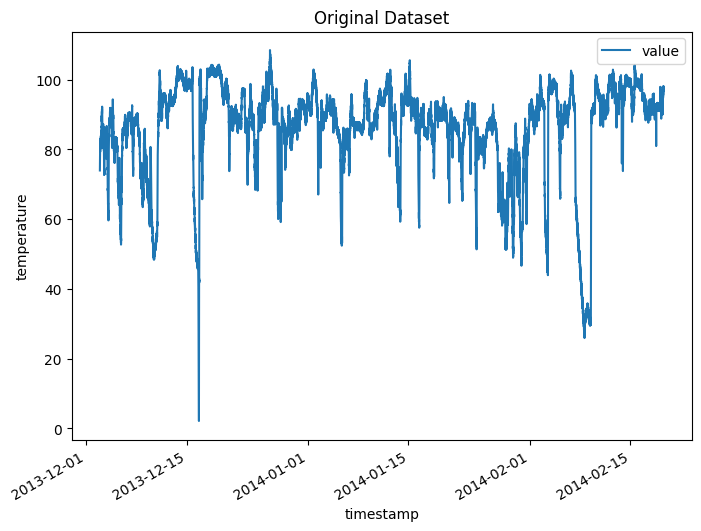

In [3]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(8, 6))
plt.ylabel("temperature")
plt.title("Original Dataset")

Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [4]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal
instances_of_anomaly = [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
                        ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
                        ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
                        ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]

In [5]:
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Make a temporary copy of the data with the timestamps for later plotting:

In [6]:
data_w_ts = data.copy()

The timestamps cover the Christmas and New Year holidays. Since we are dealing with an industrial machine, it stands to reason that its workload might be affected by holidays, and maybe even by the proximity (in time) of a holiday. Since variations in workload are expected, these are *not* considered anomalies.

In [7]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day

In [8]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

Distance from (closest) holiday:

In [9]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [10]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [11]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)

Converting timestamp into something plottable:

In [12]:
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,anomaly,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,0,2,12,21.250000,0,0,-23,13860189
1,74.935882,0,2,12,21.333333,0,0,-23,13860192
2,76.124162,0,2,12,21.416667,0,0,-23,13860195
3,78.140707,0,2,12,21.500000,0,0,-23,13860198
4,79.329836,0,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,0,19,2,15.083333,2,0,49,13928223
22691,97.804168,0,19,2,15.166667,2,0,49,13928226
22692,97.135468,0,19,2,15.250000,2,0,49,13928229
22693,98.056852,0,19,2,15.333333,2,0,49,13928232


Continuous and categorical variables:

In [13]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

Encoding categorical:

In [14]:
label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,anomaly,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,0,1,2,21.250000,0,0,-23,13860189
1,74.935882,0,1,2,21.333333,0,0,-23,13860192
2,76.124162,0,1,2,21.416667,0,0,-23,13860195
3,78.140707,0,1,2,21.500000,0,0,-23,13860198
4,79.329836,0,1,2,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,0,18,1,15.083333,2,0,49,13928223
22691,97.804168,0,18,1,15.166667,2,0,49,13928226
22692,97.135468,0,18,1,15.250000,2,0,49,13928229
22693,98.056852,0,18,1,15.333333,2,0,49,13928232


Splitting into training, validation and testing data:

In [15]:
test_ratio = 0.3
# tr_idx = np.random.choice(np.arange(data.shape[0]), size=round(data.shape[0] * (1 - test_ratio)), replace=False)
# tst_idx = list(set(range(data.shape[0])).difference(set(tr_idx)))
# len(tr_idx), len(tst_idx)

In [16]:
# tr_data = data.iloc[tr_idx]
# tst_data = data.iloc[tst_idx]
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

Normalize continuous variables:

In [17]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

Drop anomaly column for training and testing, but keep the testing one for later use:

In [18]:
train = tr_data_scaled[tr_data_scaled.anomaly == 0]
train = train.drop(columns=['anomaly'])
train

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,-1.224398,1,2,1.336685,0,0,-1.866199,-1.732808
1,-1.134136,1,2,1.348691,0,0,-1.866199,-1.732590
2,-1.023399,1,2,1.360698,0,0,-1.866199,-1.732372
3,-0.835474,1,2,1.372704,0,0,-1.866199,-1.732153
4,-0.724658,1,2,1.384711,0,0,-1.866199,-1.731935
...,...,...,...,...,...,...,...,...
15881,0.127174,25,0,1.684873,6,0,1.825637,1.731208
15882,0.120220,25,0,1.696879,6,0,1.825637,1.731426
15883,0.140016,25,0,1.708885,6,0,1.825637,1.731644
15884,0.060621,25,0,1.720892,6,0,1.825637,1.731863


In [19]:
labels_of_test = tst_data_scaled['anomaly'].tolist()
test = tst_data_scaled.drop(columns=['anomaly'])

Converting to array for inputing to the model:

In [20]:
train = train.to_numpy()
train = np.asarray(train).astype(np.float32)
test = test.to_numpy()
test = np.asarray(test).astype(np.float32)

(Btw, we assume the signal statistics are not varying)

### VAE Model [OLD]

There was an attempt at modularizing the code but for now it is not complete so we're just putting everything here :)

In [28]:
# from model.vae_model import VAEModel

# input_dim = train.shape[1]
# vae = VAEModel(input_dim, intermediate_dim=int(input_dim/2), latent_dim=int(input_dim/3))

In [30]:
from utils.sample import sample
from model.VAELossLayer import VAELossLayer

Hyperparameters:

In [50]:
train.shape[1]

8

In [66]:
input_dim = train.shape[1]
input_shape = (input_dim,)
# intermediate_dim = int(input_dim / 2)
intermediate_dim = int(input_dim / 2)
# latent_dim = int(input_dim / 3)
latent_dim = int(input_dim / 4)
beta = 0.05
# lr = 0.0001
lr = 0.01
opt = optimizers.Adam(learning_rate=lr)

Full VAE Model:

In [67]:
inputs = Input(shape=input_shape, name='encoder_input')

# Encoder model
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Reparameterization trick
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var, beta])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [68]:
vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 8)]                  0         []                            
                                                                                                  
 encoder (Functional)        (None, 2)                    56        ['encoder_input[0][0]']       
                                                                                                  
 dense_22 (Dense)            (None, 4)                    36        ['encoder_input[0][0]']       
                                                                                                  
 decoder (Functional)        (None, 8)                    52        ['encoder[0][0]']             
                                                                                            

Training:

In [69]:
history = vae_model.fit(x=train,y=train, 
                        shuffle=True,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.2)

Epoch 1/100
93/93 [==============================] - 1s 6ms/step - loss: 30772.1152 - decoder_loss: 0.4836 - vae_loss_layer_6_loss: 2.1152 - val_loss: 52432.0742 - val_decoder_loss: 0.4702 - val_vae_loss_layer_6_loss: 3.3385
Epoch 2/100
93/93 [==============================] - 0s 2ms/step - loss: 30680.0059 - decoder_loss: 0.4916 - vae_loss_layer_6_loss: 2.1152 - val_loss: 52302.8242 - val_decoder_loss: 0.4821 - val_vae_loss_layer_6_loss: 3.3385
Epoch 3/100
93/93 [==============================] - 0s 2ms/step - loss: 30593.4023 - decoder_loss: 0.4959 - vae_loss_layer_6_loss: 2.1152 - val_loss: 52215.3398 - val_decoder_loss: 0.4887 - val_vae_loss_layer_6_loss: 3.3385
Epoch 4/100
93/93 [==============================] - 0s 2ms/step - loss: 30555.4961 - decoder_loss: 0.4973 - vae_loss_layer_6_loss: 2.1152 - val_loss: 52152.8984 - val_decoder_loss: 0.4910 - val_vae_loss_layer_6_loss: 3.3385
Epoch 5/100
93/93 [==============================] - 0s 2ms/step - loss: 30525.0449 - decoder_loss: 

Plotting the model loss:

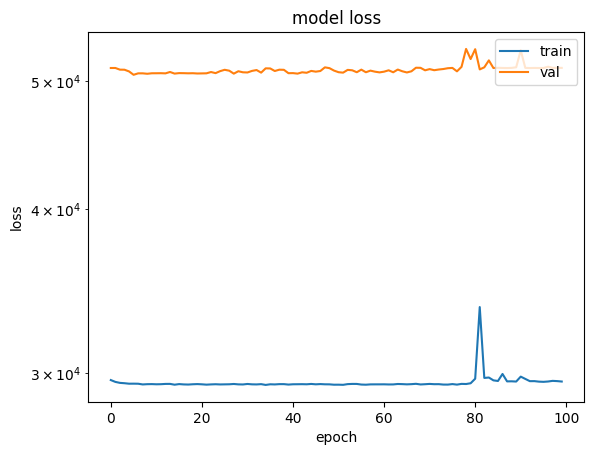

In [65]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');
plt.show()

### VAE Model [NEW]

Hyperparameters:

In [ ]:
cont_features = ['value', 'hour_min', 'gap_holiday', 't'] 
cat_features = ['day_of_week', 'holiday']

In [70]:
embedding_sizes = [(7, 16), (2, 16)]  # Example values for demonstration
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
layer_sizes = [64, 128, 256, 128, 64]
batch_size = 128
epochs = 60
kld_beta = 0.05,
lr = 0.001
# embed_cats = [len(tr_data_scaled[c].unique()) for c in cat_features]
latent_dim = 16

Full VAE Model:

In [80]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, out_dim, bn=True):
        super(CustomLayer, self).__init__()
        self.dense = tf.keras.layers.Dense(out_dim)
        self.bn = None
        if bn:
            self.bn = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(0.1)

    def call(self, inputs):
        x = self.dense(inputs)
        if self.bn:
            x = self.bn(x)
        return self.activation(x)

class Encoder(tf.keras.Model):
    def __init__(self, embedding_sizes, cont_vars, layer_sizes, latent_dim, batch_norm=True):
        super(Encoder, self).__init__()
        self.embeddings = [tf.keras.layers.Embedding(n_cats, emb_size) for n_cats, emb_size in embedding_sizes]
        in_dim = sum(emb_size for _, emb_size in embedding_sizes) + len(cont_vars)
        self.layers = [CustomLayer(out_dim, batch_norm) for out_dim in layer_sizes]
        self.mu = tf.keras.layers.Dense(latent_dim)
        self.logvar = tf.keras.layers.Dense(latent_dim)

    def call(self, inputs):
        x_cont, x_cat = inputs
        x_embed = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_embed = tf.concat(x_embed, axis=1)
        x = tf.concat([x_embed, x_cont], axis=1)
        for layer in self.layers:
            x = layer(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar, x

class Decoder(tf.keras.Model):
    def __init__(self, embedding_sizes, cont_vars, layer_sizes, latent_dim, batch_norm=True):
        super(Decoder, self).__init__()
        hidden_dims = [latent_dim] + layer_sizes[::-1]
        out_dim = sum(emb_size for _, emb_size in embedding_sizes) + len(cont_vars)
        self.layers = [CustomLayer(out_dim, batch_norm) for out_dim in hidden_dims]
        self.reconstructed = tf.keras.layers.Dense(out_dim)

    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return self.reconstructed(x)


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, kld_beta):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kld_beta = kld_beta

    def reparameterize(self, mu, logvar):
        if self.training:
            std = tf.exp(0.5 * logvar)
            eps = tf.random.normal(tf.shape(std))
            return eps * std + mu
        else:
            return mu

    def call(self, batch):
        x_cont, x_cat = batch
        mu, logvar, x = self.encoder((x_cont, x_cat))
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, x

    def loss_function(self, obs, recon, mu, logvar):
        recon_loss = tf.reduce_mean(tf.abs(recon - obs))
        kld = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))
        return recon_loss, kld

    def train_step(self, batch):
        x_cont, x_cat = batch
        with tf.GradientTape() as tape:
            recon, mu, logvar, x = self.call(batch)
            recon_loss, kld = self.loss_function(x, recon, mu, logvar)
            loss = recon_loss + self.kld_beta * kld
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'total_loss': loss, 'recon_loss': recon_loss, 'kld': kld}

# Define your hyperparameters and dataset here

# Initialize Encoder and Decoder
encoder = Encoder(embedding_sizes, cont_vars, layer_sizes, latent_dim)
decoder = Decoder(embedding_sizes, cont_vars, layer_sizes, latent_dim)

# Initialize VAE model
vae_model = VAE(encoder, decoder, kld_beta)

# Compile the model
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

AttributeError: Can't set the attribute "layers", likely because it conflicts with an existing read-only @property of the object. Please choose a different name.

In [79]:
# Train the model
history = vae_model.fit(train, epochs=epochs)

Epoch 1/60


OperatorNotAllowedInGraphError: in user code:

    File "C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\nickf\AppData\Local\Temp\ipykernel_25740\2608588032.py", line 78, in train_step
        x_cont, x_cat = batch

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');
plt.show()